# U-Net customizada linha plantio IV

# Add jupyter_contrib_nbextensions

In [ ]:
!pip install jupyter_contrib_nbextensions

In [ ]:
!jupyter contrib nbextension install --user

In [ ]:
!jupyter nbextension enable varInspector/main

## Enable
    L1
        Collapsible Headings
        Highlight selected word
    L2
        ExecuteTime
        Table of Contents
        Variable Inspector
    L3
        contrib_nbextensions_help_item
        Hinterland
        Nbextensions dashboard tab
        Snippets Menu
    L4
        Nbextensions edit menu item
        spellchecker

# Imports

In [ ]:
import numpy as np
import os
import cv2
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

# save predit img_pr
import glob

# split data
from sklearn.model_selection import train_test_split


# Set to use GPU

In [ ]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))

tf.config.experimental.set_memory_growth(physical_devices[0], True)


# U-Net functions

In [ ]:
# Example
# https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-whale-tails.ipynb

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [ ]:
class ModelSaver:
    def __init__(self, history, base_output_path):
        self.history = history
        self.base_output_path = base_output_path
        try:
            #os.mkdir(base_output_path)
            os.makedirs(base_output_path)
        except OSError as error:
            print(error)

    def saveModel(self, model):
        fileName = os.path.join(self.base_output_path,"result.h5")
        model.save(fileName)
        print("saved to:", fileName)

    def plotAndSaveMetrics(self, metric_name, show_val):
        #plt.clf() # Clear Figure 2 with clf() function:

        plt.plot(self.history.history[str(metric_name)])
        if show_val:
            plt.plot(self.history.history['val_'+str(metric_name)])
        plt.title("Acurácia por épocas")
        plt.xlabel("épocas")
        plt.legend(['treino','validação'])
        output_path = os.path.join(self.base_output_path,"acc_por_epocas")
        plt.savefig(output_path)
        print("saved to:", output_path)
        plt.show() # end figure and plot

    def plotAndSaveLoss(self, show_val):
        plt.plot(self.history.history['loss'])
        if show_val:
            plt.plot(self.history.history['val_loss'])
        plt.title("Perda por épocas")
        plt.xlabel("épocas")
        plt.legend(['treino','validação'])
        output_path = os.path.join(self.base_output_path,"loss_por_epocas")
        print("saved to:", output_path)
        plt.savefig(output_path)
        plt.show() # end figure and plot

    def predictAndSave(self, model, imgs, nomes_imgs, images_to_show):
        predict_imgs = model.predict(imgs)

        #plot_imgs(org_imgs=imgs, mask_imgs=predict_imgs, nm_img_to_plot=10, figsize=6) #<---------

        base_output_result_img = os.path.join(self.base_output_path,"result_images")
        if(os.path.isdir(base_output_result_img) == False):
            try:
                os.mkdir(base_output_result_img)
            except OSError as error:
                print(error)

        print("writing img:")
        for i in range(len(nomes_imgs)):
            #file_name = nomes_imgs[i].replace(".jpg", ".png") #<-----------------
            #file_name = file_name.replace(".jpg", ".png")

            file_name = nomes_imgs[i]

            output_path = os.path.join(base_output_result_img , file_name)
            #print("writing img:",i," to", output_path)
            print(i, end = " ")
            cv2.imwrite(output_path, predict_imgs[i] * 255.0)

    def saveHistory(self):
        output_path = os.path.join(self.base_output_path,"history.csv")
        # convert the history.history dict to a pandas DataFrame:
        hist_df = pd.DataFrame(history.history)
        # or save to csv:
        #hist_csv_file = 'history.csv'
        with open(output_path, mode='w') as f:
            hist_df.to_csv(f)

        print("saved to:", output_path)


# Plot imgs

In [ ]:
# https://github.com/karolzak/keras-unet/blob/9b7aff5247fff75dc4e2a11ba9c45929b9166d1f/keras_unet/utils.py

MASK_COLORS = ["red", "green", "blue", "yellow", "magenta", "cyan"]

def mask_to_rgba(mask, color="red"):
    """
    Converts binary segmentation mask from white to red color.
    Also adds alpha channel to make black background transparent.

    Args:
        mask (numpy.ndarray): [description]
        color (str, optional): Check `MASK_COLORS` for available colors. Defaults to "red".

    Returns:
        numpy.ndarray: [description]
    """
    assert(color in MASK_COLORS)
    assert(mask.ndim==3 or mask.ndim==2)

    h = mask.shape[0]
    w = mask.shape[1]
    zeros = np.zeros((h, w))
    ones = mask.reshape(h, w)
    if color == "red":
        return np.stack((ones, zeros, zeros, ones), axis=-1)
    elif color == "green":
        return np.stack((zeros, ones, zeros, ones), axis=-1)
    elif color == "blue":
        return np.stack((zeros, zeros, ones, ones), axis=-1)
    elif color == "yellow":
        return np.stack((ones, ones, zeros, ones), axis=-1)
    elif color == "magenta":
        return np.stack((ones, zeros, ones, ones), axis=-1)
    elif color == "cyan":
        return np.stack((zeros, ones, ones, ones), axis=-1)

def get_cmap(arr):
    """[summary]

    Args:
        arr (numpy.ndarray): [description]

    Returns:
        string: [description]
    """
    if arr.ndim == 3:
        return "gray"
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return "jet"
        elif arr.shape[3] == 1:
            return "gray"

def zero_pad_mask(mask, desired_size):
    """[summary]

    Args:
        mask (numpy.ndarray): [description]
        desired_size ([type]): [description]

    Returns:
        numpy.ndarray: [description]
    """
    pad = (desired_size - mask.shape[0]) // 2
    padded_mask = np.pad(mask, pad, mode="constant")

    return padded_mask

def reshape_arr(arr):
    """[summary]

    Args:
        arr (numpy.ndarray): [description]

    Returns:
        numpy.ndarray: [description]
    """
    if arr.ndim == 3:
        return arr
    elif arr.ndim == 4:
        if arr.shape[3] == 3:
            return arr
        elif arr.shape[3] == 1:
            return arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2])


## Old ploplot_imgst and loadImgs

In [ ]:
def plot_imgs(org_imgs, mask_imgs, pred_imgs=None, nm_img_to_plot=10,
              figsize=4, alpha=0.5, color="red"):
    """
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    Args:
        org_imgs (numpy.ndarray): Array of arrays representing a collection of original images.
        mask_imgs (numpy.ndarray): Array of arrays representing a collection of mask images (grayscale).
        pred_imgs (numpy.ndarray, optional): Array of arrays representing a collection of prediction masks images.. Defaults to None.
        nm_img_to_plot (int, optional): How many images to display. Takes first N images. Defaults to 10.
        figsize (int, optional): Matplotlib figsize. Defaults to 4.
        alpha (float, optional): Transparency for mask overlay on original image. Defaults to 0.5.
        color (str, optional): Color for mask overlay. Defaults to "red".
    """ # NOQA E501
    assert(color in MASK_COLORS)

    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

    fig, axes = plt.subplots(
        nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize), squeeze=False
    )
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 3].imshow(
                mask_to_rgba(
                    zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(pred_imgs),
                alpha=alpha,
            )
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(
                mask_to_rgba(
                    zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(mask_imgs),
                alpha=alpha,
            )
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()

#<-----
#plot_imgs(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=10, figsize=6)


In [ ]:
def loadImgs(path_list, mode, img_channels):
    imgs = []
    nomes = []
    for path in path_list:
        files = os.listdir(path)
        files.sort()
        print("\npath:", path, " len(files):", len(files))
        for file in files:
            imgPath = os.path.join(path, file)

            #print("loanding img:",len(imgs), imgPath)
            img = cv2.imread(imgPath, mode) # TODO check need mode 0 to img mask

            if mode == 0:
                img = np.expand_dims(img, 2)
            img = img / float(255)
            imgs.append(img)
            nomes.append(file)

    return np.array(imgs), nomes


In [ ]:
path = "/media/sda2/home/j/Downloads/0del/00/iv_dl_tests/Recortes/"
#path = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/"

base_train = "A"
img_channels = 3

path_predict = "/media/sda2/home/j/Downloads/0del/00/iv_dl_tests/Teste_01E/result-images/"
#path_predict = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/Teste_01E/result-images/"

trainImgs,nomes = loadImgs([path + 'Base_' + base_train + '/'], 1, img_channels)
validImgs,nomes = loadImgs([path + 'Base_' + base_train + '_mask/'], 0, img_channels)
prImgs,nomes = loadImgs([path_predict], 0, img_channels)
print("\nLoaded images!")


## overlay ori_imgs vs mask
#plot_imgs_jb(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=5,
#          red_imgs = prImgs, figsize=6, overlay="org_imgs")

## overlay mask vs predict
# plot_imgs_jb(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=2,
#             pred_imgs = prImgs, figsize=8, overlay="mask")


In [ ]:
#plots = len(imgs)

plot_imgs(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=10, figsize=6)

## plot_imgs_jb

In [ ]:
def plot_imgs_jb(org_imgs, mask_imgs, pred_imgs=None, nm_img_to_plot=10, figsize=4, alpha=0.5, color="red",
                 overlay = "", count_star = 0, show_plot = True, save_plot = False, path_save = "", 
                lang_val = "pt"):
    """
    Image plotting for semantic segmentation data.
    Last column is always an overlay of ground truth or prediction
    depending on what was provided as arguments.
    Args:
        org_imgs (numpy.ndarray): Array of arrays representing a collection of original images.
        mask_imgs (numpy.ndarray): Array of arrays representing a collection of mask images (grayscale).
        pred_imgs (numpy.ndarray, optional): Array of arrays representing a collection of prediction masks images.. Defaults to None.
        nm_img_to_plot (int, optional): How many images to display. Takes first N images. Defaults to 10.
        figsize (int, optional): Matplotlib figsize. Defaults to 4.
        alpha (float, optional): Transparency for mask overlay on original image. Defaults to 0.5.
        color (str, optional): Color for mask overlay. Defaults to "red".
    """ # NOQA E501
    assert(color in MASK_COLORS)

    #lang_val = "pt" # pt or en
    if lang_val == "pt":
        field_1 = "Imagem original"
        field_2 = "Marcação feita \n pelo especialista"
        field_3 = "Predição"
        field_4 = "Sobreposição\n"
        label_TP= "VP"
        label_TN= "VN"
    else:
        field_1 = "Original"
        field_2 = "Ground truth"
        field_3 = "Prediction"
        field_4 = "Overlay"
        label_TP= "TP"
        label_TN= "TN"

    if nm_img_to_plot > org_imgs.shape[0]:
        nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = reshape_arr(org_imgs)
    mask_imgs = reshape_arr(mask_imgs)
    if not (pred_imgs is None):
        cols = 4
        pred_imgs = reshape_arr(pred_imgs)
    else:
        cols = 3

    fig, axes = plt.subplots(nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize),
                            squeeze=False, constrained_layout = True)

    font_size = 30
    print(f"{count_star = }")

    if overlay == "org_imgs":
        print("\n# overlay ori_imgs vs mask\n")
        pad_value = 0
    else:
        print("\n# overlay mask vs predict\n")
        #pad_value = 60
        pad_value = 50

    print("count:", end = " ")

    #axes[0, 0].set_title("Original", fontsize = font_size, pad = pad_value)
    axes[0, 0].set_title(field_1, fontsize = font_size, pad = pad_value)
    
    #axes[0, 1].set_title("Ground truth", fontsize = font_size, pad = pad_value)
    axes[0, 1].set_title(field_2, fontsize = font_size, pad = pad_value)
    if not (pred_imgs is None):
        #axes[0, 2].set_title("Prediction", fontsize = font_size, pad = pad_value)
        axes[0, 2].set_title(field_3, fontsize = font_size, pad = pad_value)

        #axes[0, 3].set_title("Overlay", fontsize = font_size, pad = pad_value)
        axes[0, 3].set_title(field_4, fontsize = font_size, pad = pad_value)
    else:
        #axes[0, 2].set_title("Overlay", fontsize = font_size, pad = pad_value)
        axes[0, 2].set_title(field_4, fontsize = font_size, pad = pad_value)

    for m in range(0, nm_img_to_plot):
        print(m + 1, end = " ")

        img_org = org_imgs[im_id]
        img_org = img_org[...,::-1] # BGR to RGB

#         axes[m, 0].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
        axes[m, 0].imshow(img_org, cmap=get_cmap(org_imgs))

        axes[m, 0].set_axis_off()
        
        mask_img = mask_imgs[im_id].copy()

        mask_img[mask_img >= 0.5] = 1
        mask_img[mask_img < 1] = 0
        mask_img = mask_img.astype('uint8')
        #print("Max mask_img:", np.max(mask_img))
        
#         axes[m, 1].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
        axes[m, 1].imshow(mask_img, cmap=get_cmap(mask_imgs))

        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            pr_img = pred_imgs[im_id].copy()
    
            pr_img[pr_img >= 0.5] = 1
            pr_img[pr_img < 1] = 0
            pr_img = pr_img.astype('uint8')
            #print("Max pr_img:", np.max(pr_img))

            #axes[m, 2].imshow(pred_imgs[im_id], cmap=get_cmap(pred_imgs))
            axes[m, 2].imshow(pr_img, cmap=get_cmap(pred_imgs))
            axes[m, 2].set_axis_off()

#             print("get_cmap(org_imgs):", get_cmap(org_imgs))
#             print("get_cmap(mask_imgs):", get_cmap(mask_imgs))
#             print("get_cmap(pred_imgs):", get_cmap(pred_imgs))

            if overlay == "org_imgs":
                axes[m, 3].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))

                axes[m, 3].imshow(mask_to_rgba(
#                                 zero_pad_mask(pred_imgs[im_id], desired_size=org_imgs_size),
                                zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                                color=color), cmap=get_cmap(pred_imgs), alpha=alpha)

            else: # overlay == "mask_imgs":
#                 axes[m, 3].imshow(mask_imgs[im_id], cmap=get_cmap(mask_imgs))
#                 axes[m, 3].imshow(pred_imgs[im_id], cmap=get_cmap(mask_imgs))

                dim0 = pr_img.shape[0]
                dim1 = pr_img.shape[1]
                zeros = np.zeros((dim0, dim1))
                img_result = np.stack((zeros, zeros, zeros), axis=-1)

                img_result = img_result.astype('uint8')
#                 print("pr_img.shape:", pr_img.shape)
#                 print("mask_img.shape:", mask_img.shape)

#                 print("img_result.shape:", img_result.shape)
#                 print("img_result.dtype:", img_result.dtype)

                i = 0
                while i < dim0:
                    #print("i", i)
                    j = 0
                    while j < dim1:
                        #print("j", j)
                        if mask_img[i][j] == pr_img[i][j]:
                            if pr_img[i][j] == 1: # True Positive
                                img_result[i][j] = (255, 255, 255) # white
                            else: # True Negative
                                img_result[i][j] = (0, 0, 0) # black
                        else:
                            if pr_img[i][j] == 1: # False Positive
                                img_result[i][j] = (255, 0, 0) # red
                            else: # False Negative
                                img_result[i][j] = (0, 0, 255) # blue FN

                        j += 1

                    i += 1

#                 print("img_result:", img_result)
#                 cv2.imwrite("img_result.png", img_result)
                axes[m, 3].imshow(img_result)

                if im_id == 0:
                    import matplotlib.patches as mpatches
#                     import matplotlib.pyplot as plt

                    white_patch = mpatches.Patch(color = "white", label = label_TP)
                    black_patch = mpatches.Patch(color = "black", label = label_TN)
                    red_patch = mpatches.Patch(color = "red", label = "FP")
                    blue_patch = mpatches.Patch(color = "blue", label = "FN")

                    axes[m, 3].legend(handles=[white_patch, black_patch, red_patch, blue_patch],
                                bbox_to_anchor=(0, 1, 1, 0.2), loc = "lower center", ncol = 4,
                                fontsize = font_size - 10, facecolor = '#EEEEEE', framealpha = 1)

            axes[m, 3].set_axis_off()
        else:
            
            img_org_2 = org_imgs[im_id]
            img_org_2 = img_org_2[...,::-1] # BGR to RGB

            #axes[m, 2].imshow(org_imgs[im_id], cmap=get_cmap(org_imgs))
            axes[m, 2].imshow(img_org_2, cmap=get_cmap(org_imgs))

        
            mask_img_2 = mask_imgs[im_id].copy()

            mask_img_2[mask_img_2 >= 0.5] = 1
            mask_img_2[mask_img_2 < 1] = 0
            mask_img_2 = mask_img_2.astype('uint8')
        
        
            axes[m, 2].imshow(
                mask_to_rgba(
                    #zero_pad_mask(mask_imgs[im_id], desired_size=org_imgs_size),
                    zero_pad_mask(mask_img_2, desired_size=org_imgs_size),
                    color=color,
                ),
                cmap=get_cmap(mask_imgs),
                alpha=alpha,
            )
            axes[m, 2].set_axis_off()
        im_id += 1

    if show_plot:
        plt.show()
    else:
        plt.clf()
        plt.close()

    if save_plot:
        fig_dpi = 50 # default is 100
        print("Saving img in local .ipynb file")
        #fig.savefig(path_save + "plot_imgs_jb_" + str(count_star) + ".png", dpi = fig.dpi) # Save plots
        fig.savefig(path_save + "p_" + str(count_star) + "_" + overlay + ".pdf", dpi = fig_dpi) # Save plots


In [ ]:
def load_selected_imgs(path, list_img, mode):
    print(f"\npath: {path} len(list_img): {len(list_img)}")

    imgs = []
    for file in list_img:
        img_path = os.path.join(path, file)
        #print(f"img_path: {img_path}")
        img = cv2.imread(img_path, mode)

        #print("Max:", np.max(img))
        if mode == 0:
            img = np.expand_dims(img, 2)

        img = img / float(255)
        imgs.append(img)

    return np.array(imgs)


In [ ]:
path = "/media/sda2/home/j/Downloads/0del/00/iv_dl_tests/Recortes/"
#path = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/"

test_use = 9 # 1 or 9

path_predict = "/media/sda2/home/j/Downloads/0del/00/iv_dl_tests/Teste_0" + str(test_use) + "E/result-images/"
#path_predict = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/Teste_01E/result-images/"

base_train = "E"

# cro 1, 3, 30, 133, 245, 378, 430, 503, 504,
# b 2 13 242 428 488 819 916

##list_img = ("A_0001.png", "A_0030.png", "A_0041.png", "A_0133.png",
##            "A_0503.png", "B_0916.png", "C_0274.png", "D_1819.png") # Used in the paper with test 9
#list_img = ("A_0001.png", "A_0030.png", "A_0041.png", "A_0133.png", "A_0503.png")

##list_img = ("B_0013.png", "B_0242.png", "B_0428.png", "B_0488.png", "B_0819.png", "B_0916.png")

##list_img = ("C_0083.png", "C_0242.png", "C_0163.png", "C_0274.png", "C_0288.png", "C_1007.png")
list_img = ("C_0083.png", "C_0163.png", "C_0274.png", "C_0288.png", "C_1007.png")

imgs = load_selected_imgs(path + 'Base_' + base_train + '/', list_img, 1)
masks = load_selected_imgs(path + 'Base_' + base_train + '_mask/', list_img, 0)
pr_imgs = load_selected_imgs(path_predict, list_img, 0)

print("\nImages loaded!")


In [ ]:
# Lapix

start = "/media/sda2/home/j/Downloads/0del/00/"
path = start + "lapix/lapix_base/"
path_predict = start + "/iv_dl_tests/results_L/"

folder_user = "test_9_U-Net_without_VI_weights_Base_E/" # Weight Base E
#folder_user = "test_9_U-Net_without_VI_weights_Base_L/" # Weight Base L

path_predict = path_predict + folder_user + "predict_Base_L/"
list_img = ("sugarcane1_0115.png" , "sugarcane1_0202.png", "sugarcane1_0322.png")

# To create a tuple with only one item, have add a comma after the item,
# otherwise Python will recognize the variable as str
list_img = ("sugarcane1_0793.png",)

list_img = ("sugarcane1_0793.png", "sugarcane1_0115.png" , "sugarcane1_0202.png", "sugarcane1_0322.png")

base_train = "L"

imgs = load_selected_imgs(path + 'Base_' + base_train + '/', list_img, 1)
masks = load_selected_imgs(path + 'Base_' + base_train + '_mask/', list_img, 0)
pr_imgs = load_selected_imgs(path_predict, list_img, 0)

print("\nImages loaded!")


## Plot selected images

In [ ]:
plots = len(imgs) # 5 imagens to good paper size

lang = "pt" # pt or en
#lang = "en"

save_plot_l = True
save_plot_l = False

## overlay ori_imgs vs mask - pred_imgs is None
plot_imgs_jb(org_imgs = imgs, mask_imgs = masks, nm_img_to_plot = plots,
                figsize = 6, overlay = "org_imgs", save_plot = save_plot_l,
                path_save = "", lang_val = lang)

## overlay mask vs predict
#plot_imgs_jb(org_imgs = imgs, mask_imgs = masks, nm_img_to_plot = plots,
#             pred_imgs = pr_imgs, figsize = 8, overlay = "mask", save_plot = save_plot_l,
#            path_save = "",lang_val = lang)

plot_imgs_jb(org_imgs = imgs, mask_imgs = masks, nm_img_to_plot = plots, pred_imgs = pr_imgs, figsize = 7,
                overlay = "mask", count_star = 0, show_plot = True, save_plot = save_plot_l,
                path_save = "", lang_val = lang)


## Plot many imgs and save on disk

In [ ]:

#plot_imgs(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=5,
#          pred_imgs = prImgs, figsize=6)

## overlay ori_imgs vs mask
#plot_imgs_jb(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=5,
#          red_imgs = prImgs, figsize=6, overlay="org_imgs")

## overlay mask vs predict
# plot_imgs_jb(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=2,
#             pred_imgs = prImgs, figsize=8, overlay="mask")

#path_save_plot = ""
path_save_plot = "/run/media/j/Files_ex/00tmp/0del/"

plots = 5
i = 0

#stop_num = 10
stop_num = len(list_img)

while i < len(list_img):
    print(f"\n{i = }")
    start = i
    end = i + plots

    org = imgs[start:end]
    mask = masks[start:end]
    pred = pr_imgs[start:end]

    #n_plot = len(imgs)

    for j,v in zip(range(1, plots + 1), list_img[start:end]):
        print(j, v, end = " ")

    plot_imgs_jb(org_imgs = org, mask_imgs = mask, nm_img_to_plot = plots, pred_imgs = pred, figsize = 8,
            overlay = "mask", count_star = i, show_plot = False, save_plot = True, path_save = path_save_plot)

    # plot_imgs_jb(org_imgs = org, mask_imgs = mask, nm_img_to_plot = plots,
    #              pred_imgs = pred, figsize = 8, overlay = "org_imgs")

    i += plots
    print("All plots done!")

    if i > stop_num:
        break
#     input()

    ## clear output
    from IPython.display import clear_output
    clear_output(wait = False)

print("\nAll done!")


# Vegetation Index

In [ ]:
vi_names = [["01_VARI", "Visible Atmospherically Resistant Index"],
            ["02_ExG", "Excess Green Index"],
            ["03_ExR", "Excess Red Vegetation Index"],
            ["04_ExB", "Excess Blue Vegetation Index"],
            ["05_EXGR", "Excess Green minus Excess Red"],
            ["06_GRVI", "Green Red Vegetation Index"],
            ["07_MGRVI", "Modified Green Red Vegetation Index"],
            ["08_GLI", "Green Leaf Index"],
            ["09_RGBVI", "Red Green Blue Vegetation Index"],
            ["10_IKAW", "Kawashima Index"]]

def split_RGB_channel(img): # return RGB channels
    ## img.dtype: uint8
    ## pixel with value 0, if 0 + 1 => 1
    ## pixel with value 255, if 255 + 1 => 0

    ## Set 1 if the value is 0
    ## Lower number of nan if calculus were backgroud was 0
    img [img == 0] = 1

    # opencv reads the images as BGR instead of RGB
    B, G, R = cv2.split(img)

    # Convert to float - 0 the sum is more then 255
    R = R.astype('float32')
    G = G.astype('float32')
    B = B.astype('float32')

    return R, G, B

def check_value_inf_nan(nameValue, value): # check if value is inf or nan
    ## numpy.ndarray
    ## 0/0 = nan
    ## >0/0 = inf, <0/0 = -inf
    ## 0/1 = 0.0

    #if np.isnan(np.min(value)) or np.isinf(np.max(value)):
    if np.isnan(np.min(value)) or np.isinf(np.max(value)) or np.isnan(np.max(value)) or np.isinf(np.min(value)):
        print("\ncheck_value_inf_nan {}".format(nameValue))
        print("np.max({}): {} np.min({}): {}".format(nameValue, np.max(value), nameValue, np.min(value)))
        #print("{}.dtype: {} {}.shape: {}".format(nameValue, value.dtype, nameValue, value.shape))
    
        value[np.isnan(value)] = 0 # Change all nan to 0

        value[np.isneginf(value)] = 0 # Change all inf to 0
        value[np.isposinf(value)] = 0 # Change all inf to 0
        #value[np.isinf(value)] = 1 # Change all inf to 01

        print("np.max({}): {} np.min({}): {}".format(nameValue, np.max(value), nameValue, np.min(value)))

#     if np.isnan(np.min(value)) or np.isnan(np.max(value)):
#         print("np.isnan(np.min(",nameValue,"))!")
#         raise Exception("np.isnan(np.min(",nameValue,"))!")

#     if np.isinf(np.max(value)) or np.isinf(np.min(value)):
#         print("np.isinf(np.max(",nameValue,"))!")
#         raise Exception("np.isnan(np.min(",nameValue,"))!")

    return value

def normalize_vi(value): # calculate IKAW
    ## normalize
# https://stackoverflow.com/questions/38376478/changing-the-scale-of-a-tensor-in-tensorflow/38377600#38377600

    min_value = np.min(value)
    max_value = np.max(value)
    #epsilon = 1e-12

    normalized_value = (value - min_value) / (max_value - min_value)

    #normalized_value = (value - min_value) / max((max_value - min_value), epsilon)
    #normalized_value = (value - min_value + epsilon) / max((max_value - min_value), 2 * epsilon)

    return normalized_value

def normalized_RGB(img): # return normalized values for each RGB channel
    R, G, B = split_RGB_channel(img)

    # 24 bits image, 8 bits for each color, has 255 (2^8) as max value
    Rn = R/255.0
    Gn = G/255.0
    Bn = B/255.0

    return Rn, Gn, Bn

def chromatic_coordinates(img): # Return cromatic coordinates for each RGB channel
    Rn, Gn, Bn = normalized_RGB(img)

    ALLn = Rn + Gn + Bn

    r = Rn / ALLn
    g = Gn / ALLn
    b = Bn / ALLn

    return r, g, b

def calc_VI_01_VARI(img): # calculate VARI
    r, g, b = chromatic_coordinates(img)

    ## RuntimeWarning: divide by zero encountered in true_divide
    vi_01_vari = (g - r) / (g + r - b)

    #vi_01_vari = check_value_inf_nan("vi_num_1_inside", vi_01_vari)

    return vi_01_vari

def calc_VI_02_ExG(img): # calculate ExG
    r, g, b = chromatic_coordinates(img)

    vi_02_ExG = 2 * g - r - b
    return vi_02_ExG

def calc_VI_03_ExR(img): # calculate ExR
    R, G, B = split_RGB_channel(img)

    vi_03_ExR = (1.4 * R - G) / ( R + G + B)
    return vi_03_ExR

def calc_VI_04_ExB(img): # calculate ExB
    R, G, B = split_RGB_channel(img)

    vi_04_ExB = (1.4 * B - G) / ( R + G + B)
    return vi_04_ExB

def calc_VI_05_ExGR(img): # calculate ExGR
    r, g, b = chromatic_coordinates(img)

    vi_02_ExG = calc_VI_02_ExG(img)
    vi_03_ExR = calc_VI_03_ExR(img)

    vi_05_ExGR = vi_02_ExG - vi_03_ExR
    return vi_05_ExGR

def calc_VI_06_GRVi(img): # calculate GRVI
    R, G, B = split_RGB_channel(img)

    vi_06_GRVI = (G - R) / (G + R)
    return vi_06_GRVI

def calc_VI_07_MGRVI(img): # calculate MGRVI
    R, G, B = split_RGB_channel(img)

    vi_07_MGRVI = (G ** 2 - R ** 2) / (G ** 2 + R ** 2)
    return vi_07_MGRVI

def calc_VI_08_GLI(img): # calculate GLI
    r, g, b = chromatic_coordinates(img)

    vi_08_GLI = (2 * g - r - b) / (-r - b)
    return vi_08_GLI

def calc_VI_09_RGBVI(img): # calculate RGBVI
    R, G, B = split_RGB_channel(img)

    vi_09_RGBVI = (G ** 2 - B * R) / (G ** 2 + B * R)
    return vi_09_RGBVI

def calc_VI_10_IKAW(img): # calculate IKAW
    R, G, B = split_RGB_channel(img)

    vi_10_IKAW = (R - B) / (R + B)
    return vi_10_IKAW

def return_vi_by_number(img, vi_num):
    # img must be 3 chanel in unit8, i.e., 0 - 255 values
    vi = ''

    if vi_num == 1:
        vi = calc_VI_01_VARI(img)
    elif vi_num == 2:
        vi = calc_VI_02_ExG(img)
    elif vi_num == 3:
        vi = calc_VI_03_ExR(img)
    elif vi_num == 4:
        vi = calc_VI_04_ExB(img)
    elif vi_num == 5:
        vi = calc_VI_05_ExGR(img)
    elif vi_num == 6:
        vi = calc_VI_06_GRVi(img)
    elif vi_num == 7:
        vi = calc_VI_07_MGRVI(img)
    elif vi_num == 8:
        vi = calc_VI_08_GLI(img)
    elif vi_num == 9:
        vi = calc_VI_09_RGBVI(img)
    elif vi_num == 10:
        vi = calc_VI_10_IKAW(img)

#     print("\n\nvi_num:", vi_num)
#     print("\nnp.max(vi):", np.max(vi), "np.min(vi):", np.min(vi))
#     print("vi.dtype:", vi.dtype, "vi.shape:", vi.shape)

#     print("\ncheck_value_inf_nan")
    vi = check_value_inf_nan("vi_num_" + str(vi_num), vi)
#     print("np.max(vi):", np.max(vi), "np.min(vi):", np.min(vi))
#     print("vi.dtype:", vi.dtype, "vi.shape:", vi.shape)

#-----------------------------------------------------------------------------------------
#     print("\nnormalize_vi")
    vi = normalize_vi(vi)
#-----------------------------------------------------------------------------------------

#     print("np.max(vi):", np.max(vi), "np.min(vi):", np.min(vi))
#     print("vi.dtype:", vi.dtype, "vi.shape:", vi.shape)

    return vi


In [ ]:
def combine_img_VIs(img, vi_config, use_RGB):
    vi_used = vi_config[1]

    #print("\n\nimg:", img.shape)
    img_back = img.copy()

    img = img / float(255)
    #img = np.array(img)

    for i, vi_num in enumerate(vi_used):
#        print("\n\nvi_names[vi_num - 1]:", vi_names[vi_num - 1])
        vi = return_vi_by_number(img_back, vi_num)

        #print("\nnp.max(vi):", np.max(vi), "np.min(vi):", np.min(vi))
        #print("vi.dtype:", vi.dtype, "vi.shape:", vi.shape)

        
        if i == 0:
            if use_RGB:
                img_aux = np.dstack((img, vi))
            else:
                #print("vi.shape:", vi.shape)
                vi = np.expand_dims(vi, 0) # vi.shape: (256, 256) to (1, 256, 256)
                img_aux = np.dstack((vi))

                #print("vi.shape:", vi.shape)
                #print("img_aux.shape:", img_aux.shape)
    
        else:
            img_aux = np.dstack((img_aux, vi))

        #print("\nimg_back.shape:", img_back.shape)
        #print("img_aux.shape:", img_aux.shape)

    #print("img_aux.shape:", img_aux.shape)
    #print("\nnp.max(img_aux):", np.max(img_aux), "np.min(img_aux):", np.min(img_aux))
    #print("img_aux.dtype:", img_aux.dtype, "img_aux.shape:", img_aux.shape)
    
    return img_aux

## test
from os import path
path_folder = "/media/sda2/home/j/Downloads/0del/00/iv/Recortes/Base_A/"

if not path.exists(path_folder):
    path_folder = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/"

imgLoad = path_folder + "A_0002.png"
imgLoad = path_folder + "A_0431.png"

print("imgLoad:", imgLoad)
img = cv2.imread(imgLoad)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show()

use_vi = True
VIs_to_use = [1]
#VIs_to_use = [1. 2, 3]
#VIs_to_use = [1,2,3,4,5,6,7,8,9,10]

use_RGB = False
#use_RGB = True
vi_config = (use_vi, VIs_to_use)

img_vi = combine_img_VIs(img, vi_config, use_RGB)
print("\nimg_vi.shape:", img_vi.shape)


imgLoad: E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/A_0431.png


AttributeError: ignored

In [ ]:
def load_imgs_names(path):
    names = []
    files = os.listdir(path)
    files.sort()
    #imgCount = len(files)

    print("\npath:", path, " len(files):", len(files))
    for file in files:
        names.append(file)

    return names #, imgCount


In [ ]:
def adjust_data(img_batch, mask_batch, vi_config, use_RGB):
    #print("\n\nimg_batch.shape:", img_batch.shape)
    #print("mask_batch.shape:", mask_batch.shape)

    if vi_config[0]: # check if use VI
        # first axis is zero, for adding images along it
        # create a 4d np array to add the images (with IV) in first space imgs_vi[_]
        if use_RGB:
            imgs_vi = np.empty((0, 256, 256, len(vi_config[1]) + 3))
        else:
            imgs_vi = np.empty((0, 256, 256, len(vi_config[1])))

        count_imgs = img_batch.shape[0] # count imgs, the batch_size
        for i in range(count_imgs): # For each img create all IVs and add them together
            img = img_batch[i]
            #print("\n--->i:", i + 1, "img.shape: ", img.shape)

            img_tmp_vi = combine_img_VIs(img, vi_config, use_RGB)
            #print("\n1 adjust_data - img_tmp_vi.shape:", img_tmp_vi.shape)

            # add a new axis to each image and append them to result
            # add the img (with the IVs) to the array using a "newaxis"
            imgs_vi = np.append(imgs_vi, img_tmp_vi[np.newaxis, ...], axis=0)

            #img2 = img.copy()
            #img2 = img2.astype('uint8')
            ##print(img2)
            #plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
            #plt.show()
            #input()

        img_batch = imgs_vi.copy()
        #print("\nf adjust_data - img_batch.shape:", img_batch.shape) # (256, 256, 4)

    else: #not using VI, adjust img_batch
        img_batch = img_batch / float(255)
        #img_batch = np.array(img_batch)

    # Adjust mask_batch
    mask_batch = mask_batch / float(255)
    #print("b mask_batch.shape:", mask_batch.shape)
    #mask_batch = np.expand_dims(mask_batch, 2)
    #print("a mask_batch.shape:", mask_batch.shape)
    #print("img_batch.shape:", img_batch.shape)
    #mask_batch = np.array(mask_batch)

    #if mode == 0:
    #    img = np.expand_dims(img, 2)

#<--------------------------------------------------------------
#    mask_batch[mask_batch >= 0.5] = 1
#    mask_batch[mask_batch < 0.5] = 0

    ## VI may have negative values, so not set to uint8, stay in float32
    #img_batch = img_batch.astype('uint8')
#    mask_batch = mask_batch.astype('uint8')
#<--------------------------------------------------------------

    #print("\n\nnp.max(img_batch):", np.max(img_batch), "np.min(img_batch):", np.min(img_batch))
    #print("img_batch.dtype:", img_batch.dtype)

    #print("np.max(mask_batch):", np.max(mask_batch), "np.min(mask_batch):", np.min(mask_batch))
    #print("mask_batch.dtype:", mask_batch.dtype)

    return img_batch, mask_batch


# make_generator_2

In [ ]:
def make_generator_2(data_frame, batch_size, folder_path, img_folder, mask_folder, type_make, use_RGB):
    count_img = len(data_frame)
    print("\nmake_generator2 Found", count_img, "image filenames - type_make:", type_make)

    i = 0
    next_i_value = False
    #while i <= count_img:
    while True:
        if i == count_img: # restart i to next epoch
            #print("\nNew epoch - type_make:", type_make, "\n")
            i = 0

        if next_i_value:
            i = j
            next_i_value = False

        #imgs_vi = np.empty((0, 256, 256, len(vi_config[1]) + 3))
        img_batch = np.empty((0, 256, 256, 3))
        mask_batch = np.empty((0, 256, 256, 1))

        j = i
        next_step = i + batch_size
        #print("j", j, "next_step", next_step)
        #print("\n\ndata_frame", data_frame[i:i + batch_size], "\n")

        count_batch = 0
        while count_batch < batch_size:
            count_batch += 1

            if j == count_img:
                #print("---j == count_img---type_make:", type_make)
                j = 0
                next_i_value = True

            #file_name = "/" + data_frame.loc[j,:][0]
            file_name = "/" + data_frame.loc[j][0]
            #print("file_name:", file_name)

            img_name = folder_path + img_folder + file_name
            #print("img_name:", img_name)
            mask_name = folder_path + mask_folder + file_name
            #print("mask_name:", mask_name)

            img = cv2.imread(img_name, 1) # Read as RGB
            mask = cv2.imread(mask_name, 0) # Read as grayscale

            # expand_dims 256 x 256 to 256x256x1
            mask = np.expand_dims(mask, 2)

            #print("img.shape:", img.shape)
            #print("mask.shape:", mask.shape)

            img_batch = np.append(img_batch, img[np.newaxis, ...], axis=0) #img_batch[j] = img
            mask_batch = np.append(mask_batch, mask[np.newaxis, ...], axis=0) #mask_batch[j] = mask

            j += 1

            #print("img[100,100]", img[100,100])
            #imsave("img2.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            #imsave("mask.png", mask, check_contrast=False)
            #input()

        i += batch_size

#        print("before adjust_data img_batch.shape:", img_batch.shape)
#        print("before adjust_data mask_batch.shape:", mask_batch.shape)

        img_batch, mask_batch = adjust_data(img_batch, mask_batch, vi_config, use_RGB)

#        print("after adjust_data img_batch.shape:", img_batch.shape)
#        print("after adjust_data mask_batch.shape:", mask_batch.shape)

        yield(img_batch, mask_batch)


# Variables

In [ ]:
#f = [16, 32, 64, 128, 256] # Test 01
#f = [16, 32, 64, 128] # Test 02
#f = [16, 32, 64] # Test 03
#f = [16, 32] # Test 04
#f = [16] # Test 05
#f = [16, 16] # Test 06
#f = [16, 16, 16] # Test 07
#f = [16, 16, 16, 16] # Test 08
#f = [16, 16, 16, 16, 16] # Test 09
#f = [32] # Test 10
#f = [64] # Test 11
#f = [128] # Test 12

#----------

#base_train = 'E'
#base_output_path = '.\\Teste_09' + basebase_train_treino

#path_carregar_pesos = ''
#path_carregar_pesos = base_output_path + '/result.h5'

#base_output_path = 'Teste_12' + base_train

#---------------------------------------------------------

kernel_size = (3, 3) #(3, 3)
padding = "same" #"same"
strides = 1 #1
image_size = 256 #256
epochs = 50 #50
#epochs = 5 #50
#epochs = 1 #50
validation_split = 0.2 #0.2

# batch_size = 8 # ResourceExhaustedError: Graph execution error,
# Reduce your Dimension because of the limited RAM on GPU
batch_size = 8 # 8


In [ ]:
#--------------------------------------------------------------------------------------------------
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.07,
                    height_shift_range=0.07,
                    shear_range=0.07,
                    zoom_range=0.07,
                    horizontal_flip=True,
                    fill_mode='nearest')

#data_gen_args = dict() #<----

#use_data_gen_args = True # True - Use data_gen_args
use_data_gen_args = False # False - Don't use data_gen_args

shuffleData = False # whether to shuffle the data (default: True)

#save_trans_path = "transformation" #save_to_dir = None
save_trans_path = None

#--------------------------------------------------------------------------------------------------

seed = 42 # 0.93
#seed = 1 # 0.9445
#seed = 9

save_predict = True
#save_predict = False


In [ ]:
def make_dirs(output_dir):
    try:
        os.makedirs(output_dir)
    except OSError as error:
        print(error)
    else:
        print ("\nCreated the directory:", output_dir)

# detect the current working directory and print it
path = os.getcwd()
print ("Current working directory:", path)


Current working directory: /content


# Run

In [ ]:
# https://faroit.com/keras-docs/2.0.2/metrics/
# https://stackoverflow.com/questions/59054564/dice-coefficient-above-1
# https://github.com/keras-team/keras/issues/3611

import keras.backend as K

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_loss(y_true, y_pred):
#     #return - dice_coef(y_true, y_pred)
#     return 1 - dice_coef(y_true, y_pred)


In [ ]:
### 01 VARI  Visible Atmospherically Resistant Index
# 02 ExG   Excess Green Index
# 03 ExR   Excess Red Vegetation Index
# 04 ExB   Excess Blue Vegetation Index
# 05 EXGR  Excess Green minus Excess Red
# 06 GRVI  Green Red Vegetation Index
# 07 MGRVI Modified Green Red Vegetation Index
# 08 GLI   Green Leaf Index
# 09 RGBVI Red Green Blue Vegetation Index
# 10 IKAW  Kawashima Index

#path = "/media/sda2/home/j/Downloads/0del/00/iv/Recortes/"
path = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/"

#letras_train = 'ABCDE'
#letras_train = 'A'
#letras_train = 'B'
letras_train = 'E'
#letras_train = 'L'

#test = 1 #f = [16, 32, 64, 128, 256] # Test 01
test = 9 #f = [16, 16, 16, 16, 16] # Test 09
#test = 13 #f = [16, 16, 16, 16, 16, 16] # Test 13
#test = 14 #f = [16, 16, 16, 16, 16, 16] # Test 14
#test = 15 #f = [16, 16, 16, 16, 16, 16, 16] # Test 15
#test = 16 #f = [16, 32, 64, 128, 256, 512] # Test 16

train_model = True
#train_model = False # Make predict

use_vi = False #<--------------------------------
#use_vi = True #<--------------------------------

use_RGB = True # Use RGB channels
#use_RGB = False

# 1 - loss nan - need remove inf and nan
# 2 to 10 ok

VIs = [1]
#VIs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

metrics_use = "acc"
#metrics_use = "dice_coef"

if not use_vi:
    VIs = [1]
    use_RGB = True
print("\nVIs:", VIs)

# <-------------------------------------------------------
for v in VIs:
    VIs_to_use = [v]

# <-------------------------------------------------------    
# run_value = [
#         [1, 2, 3, 4, 5],
#         [5, 6, 7, 8, 9, 10],
#         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#     ]

# for v in run_value:
#     print("v:", v)
#     VIs_to_use = v

# <-------------------------------------------------------

    print("\nVI normalized")
    #print("\nVI NOT normalized")

    vi_config = (use_vi, VIs_to_use)
    if vi_config[0]:
        print("\nUsing VI - vi_config[0]:", vi_config[0])
        #print(type(vi_config[1]))

        if use_RGB:
            img_channels = 3 + len(vi_config[1]) # Count of channel in the img: RGB + VIs
        else:
            img_channels = len(vi_config[1]) # Count of channel in the img: VIs

        print("\nVI in use:", vi_config[1])
        list_VIs = ''
        for val in vi_config[1]:
            print(vi_names[val - 1])
            list_VIs += "_" + vi_names[val - 1][0]

        print("\nlist_VIs:", list_VIs)
    else:
        print("\nNot using VI - vi_config[0]:", vi_config[0])
        img_channels = 3 # Count of channel in the img and input U-Net model
    print("\nimg_channels:", img_channels)

    for base_train in letras_train:
        dataset_img_folder = "Base_" + base_train
        dataset_mask_folder = dataset_img_folder + "_mask"
        print("\ndataset_img_folder:", dataset_img_folder)

        if test == 1:
            f = [16, 32, 64, 128, 256] # Test 01
        elif test == 9:
            f = [16, 16, 16, 16, 16] # Test 09
        elif test == 13:
            f = [16, 16, 16, 16, 16, 16] # Test 13
        elif test == 14:
            f = [16, 16, 16, 16, 16, 16, 16] # Test 14
        elif test == 15:
            f = [16, 16, 16, 16, 16, 16, 16, 16] # Test 15
        elif test == 16:
            f = [16, 32, 64, 128, 256, 512] # Test 16
        else:
            raise Exception("Test: " + str(f) + "- f not configured!")

############################################################################################################################################################################
        #f = [16, 32, 64, 128, 256] # Test 01
        #f = [16, 32, 64, 128] # Test 02
        f = [16, 32, 64] # Test 03
        #f = [16, 32] # Test 04
        #f = [16] # Test 05
        #f = [16, 16] # Test 06
        #f = [16, 16, 16] # Test 07
        #f = [16, 16, 16, 16] # Test 08
        #f = [16, 16, 16, 16, 16] # Test 09
        #f = [32] # Test 10
        #f = [64] # Test 11
        #f = [128] # Test 12

        #f = [16, 16, 16, 16, 16, 16] # Test 13
        #f = [16, 16, 16, 16, 16, 16, 16] # Test 14
        #f = [16, 16, 16, 16, 16, 16, 16, 16] # Test 15
        #f = [16, 32, 64, 128, 256, 512] # Test 16
############################################################################################################################################################################


        if use_RGB and img_channels == 3:
            base_output_path = "results/test_" + str(test) + "_U-Net_without_VI_weights_Base_" + base_train
        else: # img_channels >= 4
            base_output_path = "results/test_" + str(test) + "_U-Net_VI" + list_VIs + "_weights_Base_" + base_train

        print("\nConfig:", base_output_path)
        print("test:", test, "f:", f)
        print("use_RGB:", use_RGB)
        #print("Configurações carregadas")

        #=======================================================================
        inputs = keras.layers.Input((image_size, image_size, img_channels)) # img_channels => 3
        p0 = inputs
        down_blocks_layers = [{
            "p": p0
        }]
        for i in range(len(f) - 1):
            c, p = down_block(down_blocks_layers[i]["p"], f[i])
            down_blocks_layers.append({
                "c": c,
                "p": p
            })

        bn = bottleneck(down_blocks_layers[len(down_blocks_layers)-1]["p"], f[len(f)-1])
        up_blocks_layers = [bn]

        for i in range(len(f) - 1):
            invertI = len(f) - i - 1
            p = up_block(up_blocks_layers[i],down_blocks_layers[invertI]["c"], f[invertI])
            up_blocks_layers.append(p)

        outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up_blocks_layers[len(up_blocks_layers) - 1])
        model = keras.models.Model(inputs, outputs)

        ##model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

        if metrics_use == "acc":
            print("metrics=[\"acc\"]")
            model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
        elif metrics_use == "dice_coef":
            print("metrics=[dice_coef]")
            model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[dice_coef])

            #model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef, "acc"])

        model.summary()
        print("Modelo criado!")
        #=======================================================================

        if train_model:
            path_carregar_pesos = ''

    #-------------------------------------------------------------------------------------------------------------
            # --- JB 1
            #names, imgCount = load_imgs_names(path + 'Base_' + base_train + '/')
            names = load_imgs_names(path + 'Base_' + base_train + '/')

            train_index, test_index = train_test_split(names, test_size = validation_split,
                                                       shuffle = True, random_state = seed)

            train_data_frame = pd.DataFrame(train_index, columns = ['filename'])
            test_data_frame = pd.DataFrame(test_index, columns = ['filename'])

            print("\nshuffle the data inside make_generator:", shuffleData)

            print("\ntrain_data_frame\n", train_data_frame, "\n\ntest_data_frame\n", test_data_frame)

#             print("\nmake_generator: make_generator")
#             train_generator = make_generator(train_data_frame, batch_size, path, dataset_img_folder,
#                         dataset_mask_folder, aug_dict = data_gen_args, image_color_mode = "rgb",
#                         save_to_dir = save_trans_path, target_size = (image_size, image_size),
#                         seed = seed, use_data_gen_args = use_data_gen_args, shuffle = shuffleData, use_RGB = use_RGB)

#             test_generator = make_generator(test_data_frame, batch_size, path, dataset_img_folder,
#                         dataset_mask_folder, aug_dict = '', image_color_mode = "rgb",
#                        save_to_dir = save_trans_path, target_size = (image_size, image_size),
#                        seed = seed, use_data_gen_args = False, shuffle = shuffleData, use_RGB = use_RGB)

            print("\nmake_generator: make_generator_2")
            train_generator = make_generator_2(train_data_frame, batch_size, path, dataset_img_folder,
                                               dataset_mask_folder, "train", use_RGB)

            test_generator = make_generator_2(test_data_frame, batch_size, path, dataset_img_folder,
                                              dataset_mask_folder, "test", use_RGB)

            train_samples = len(train_index)
            test_samples = len(test_index)
            steps_p_epoch = int(train_samples / batch_size)
            val_steps = int(test_samples / batch_size)

            print(" len(train_index):", len(train_index), "len(test_index):", len(test_index))

            print("\ndataset_img_folder:", dataset_img_folder) 
            print("batch_size:", batch_size)
            print("train_samples:", train_samples)
            print("test_samples:", test_samples)
            print("steps_p_epoch:", steps_p_epoch)
            print("val_steps:", val_steps)
            print("validation_split:", validation_split)
            print("use_data_gen_args:", use_data_gen_args)
            print()

            #raise Exception("Error - loadImgsNames:")
    #-------------------------------------------------------------------------------------------------------------
            # --- Backes
            #trainImgs, nomes = loadImgs([path + 'Base_' + base_train + '/'], 1, img_channels)
            #validImgs, nomes = loadImgs([path + 'Base_' + base_train + '_mask/'], 0, img_channels)

            # --- JB 2
#             trainImgs = loadImgs_new([path + 'Base_' + base_train + '/'], 1)
#             validImgs = loadImgs_new([path + 'Base_' + base_train + '_mask/'], 0)

#             print("\nnp.max(trainImgs):", np.max(trainImgs), "np.min(trainImgs):", np.min(trainImgs))
#             print("trainImgs.dtype:", trainImgs.dtype, "trainImgs.shape:", trainImgs.shape)

            #print("Imagens carregadas")

            #=======================================================================
            #plot_imgs(org_imgs=trainImgs, mask_imgs=validImgs, nm_img_to_plot=10, figsize=6)

            #=======================================================================
            #if(path_carregar_pesos == ''):

            # model.fit verbose, verbose = 0 will show you nothing (silent)
            # verbose=1 will show you an animated progress bar
            # verbose=2 will just mention the number of epoch

            # --- Backes and JB 2
#             history = model.fit(trainImgs, validImgs, epochs = epochs, batch_size = batch_size,
#                                 validation_split = validation_split, verbose = 1)

            # --- JB 1
            history = model.fit(train_generator, validation_data = test_generator, validation_steps = val_steps,
                                steps_per_epoch = steps_p_epoch, epochs = epochs)

            print('\nModelo treinado')
        else:
            path_carregar_pesos = base_output_path + '/result.h5'
            print("\npath_carregar_pesos:", path_carregar_pesos)

            model.load_weights(path_carregar_pesos)
            print('\nPesos carregados')

            history = '' # To not make error "history not defined"

        #=======================================================================

        modelSaver = ModelSaver(history, base_output_path)
        print('\nModelSaver criado!')

        print("base_output_path:", base_output_path)

        #=======================================================================
        if train_model:
            if metrics_use == "acc":
                print("metrics=[\"acc\"]")
                modelSaver.plotAndSaveMetrics("acc", True)
            elif metrics_use == "dice_coef":
                print("metrics=[dice_coef]")
                modelSaver.plotAndSaveMetrics("dice_coef", True) #<-----------------

            #modelSaver.plotAndSaveMetrics("dice_coef_loss", True)

            #modelSaver.plotAndSaveMetrics("mean_io_u", True) #<-----------------
            modelSaver.plotAndSaveLoss(True)

            modelSaver.saveModel(model)
            modelSaver.saveHistory()

        #=======================================================================
        else:
            #letras_predict="A"
            #letras_predict="ABCDE"
            #letras_predict="L"
            letras_predict="ABCDEL"

            for base_predict in letras_predict:
                print("\n\nPredict of Base", base_predict, "with weights of Base", base_train)

                nr_files = len(glob.glob(path + "Base_" + base_predict + "/*.png"))
                print("nr_files:", nr_files)

                output_dir = base_output_path + "/result_images/predict_Base_" + base_predict
                print("\noutput_dir:", output_dir)

                make_dirs(output_dir)

                i = 1
                for name in sorted(glob.glob(path + "Base_" + base_predict + "/*.png")):
                    #print("name:", name)

                    img = cv2.imread(name)
                    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    #plt.show()

                    #print("\nimg:", img)

                    #img_batch = img
                    #mask_batch = img.copy()
                    if vi_config[0]:
                        img_tmp = combine_img_VIs(img, vi_config, use_RGB)
                    else: #not using VI, adjust img_batch
                        img_tmp = img / float(255)
                        #img_tmp = np.array(img_tmp)

                    ##img_tmp = adjust_data(img_batch, mask_batch, vi_config)

                    #print("\nimg_tmp:", img_tmp)
                    #print("\nimg.shape:", img.shape)
                    #print("img_tmp.shape:", img_tmp.shape)

                    #imgs_vi = np.empty((0, 256, 256, len(vi_config[1]) + 3))
                    #imgs_vi = np.append(imgs_vi, img_tmp[np.newaxis, ...], axis=0)
                    #imgs_vi = np.append(imgs_vi, img_tmp[np.newaxis, ...], axis=0)

                    pr = model.predict(np.array([img_tmp]))[0]
                    #pr = model.predict(np.array([img_tmp]))

                    #print("pr.shape:", pr.shape)
                    #print("pr.dtype:", pr.dtype)
                    #print("\npr", pr)

                    #plt.imshow(pr * 255.0)
                    #plt.imshow(pr)
                    #plt.show()

    # <----------------------------------------------------------------------
                    #pr = np.array(pr)
                    #pr = pr[:,:, 0]
                    #pr[pr >= 0.5] = 1
                    #pr[pr < 1] = 0
                    #pr = pr * 255
                    #pr = pr.astype('uint8')
    # <----------------------------------------------------------------------

                    #print("\npr.shape:", pr.shape)
                    #print("pr.dtype:", pr.dtype)
                    #print("\npr", pr)

                    if save_predict :
                        name = name.replace("\\","/") # change "\" to "/"
                        name = name.split('/')[-1]
                        #print("name:", name)

                        name_predict = output_dir + "/" + name
                        #print("name_predict:", name_predict)

                        #imsave(name_predict, pr, check_contrast = False)
                        #print("writing img:",i," to", output_path)

                        cv2.imwrite(name_predict, pr * 255.0)
                        #cv2.imwrite(name_predict, pr)

                    #plt.imshow(pr * 255.0)
                    #plt.show()
                    #input()

                    #avaliaImgs,avaliaImgsNomes = loadImgs([path + "/Base_"+ base_predict + '/'], 1, img_channels, vi_num)
                    #print("\nCount imagens:", len(avaliaImgs))

                    #modelSaver.predictAndSave(model, avaliaImgs, avaliaImgsNomes, 5)
                    print(i, end=' ') # img print number running
                    i += 1

            print("\n\n# train_model is false, need just one to predict")
            break # train_model is false, need just one to predict

print("\n\nAll Done!\n")



VIs: [1]

VI normalized

Not using VI - vi_config[0]: False

img_channels: 3

dataset_img_folder: Base_E

Config: results/test_9_U-Net_without_VI_weights_Base_E
test: 9 f: [16, 32, 64]
use_RGB: True
metrics=["acc"]
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 256, 256, 16  448         ['input_13[0][0]']               
                                )                                                                 
                                                                         

NameError: ignored

## End Run

#Plot model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install tensorflow 2.6.4

In [ ]:
!pip install tensorflow==2.6.4
import tensorflow as tf
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.3/464.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 17.1 MB/s eta 0:00:00
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=3a799ecb2a40663bc9c7dd200b36b8a67081dbe1d23765caf52c24e3674bf6ae
  Stored in directory: /root/.cache/pip/wheels/f1/60/77/22b9b5887bd47

## Install pydotplus

In [ ]:
pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Install graphviz

In [ ]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone plot_model

In [ ]:
!git clone https://github.com/ryuuzaki42/plot_model

Cloning into 'plot_model'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 86 (delta 38), reused 61 (delta 20), pack-reused 0
Unpacking objects: 100% (86/86), 1.29 MiB | 712.00 KiB/s, done.


## Load/Exec file

In [ ]:
execfile("/content/plot_model/plot_model/plot_model.py")

## Make the plot

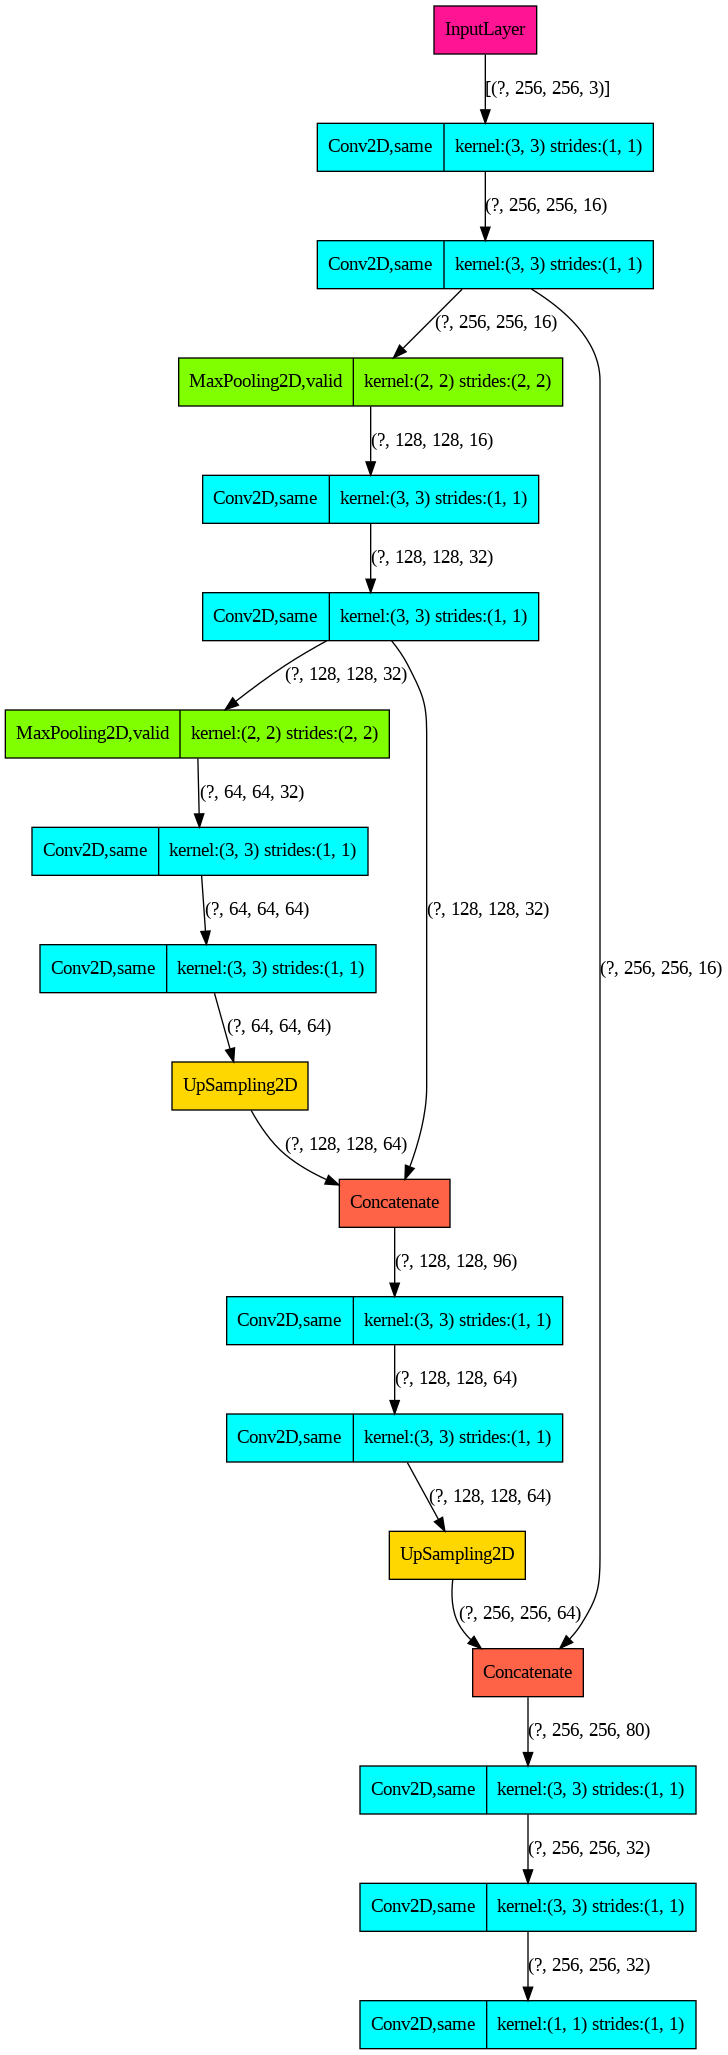

In [ ]:
#plot_model(model)

# Default
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)

# My use
num_file = "12"
file_name_s = "model_" + num_file + "_s.png"

plot_model(model, to_file=file_name_s, show_shapes=False, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)

##Original plot

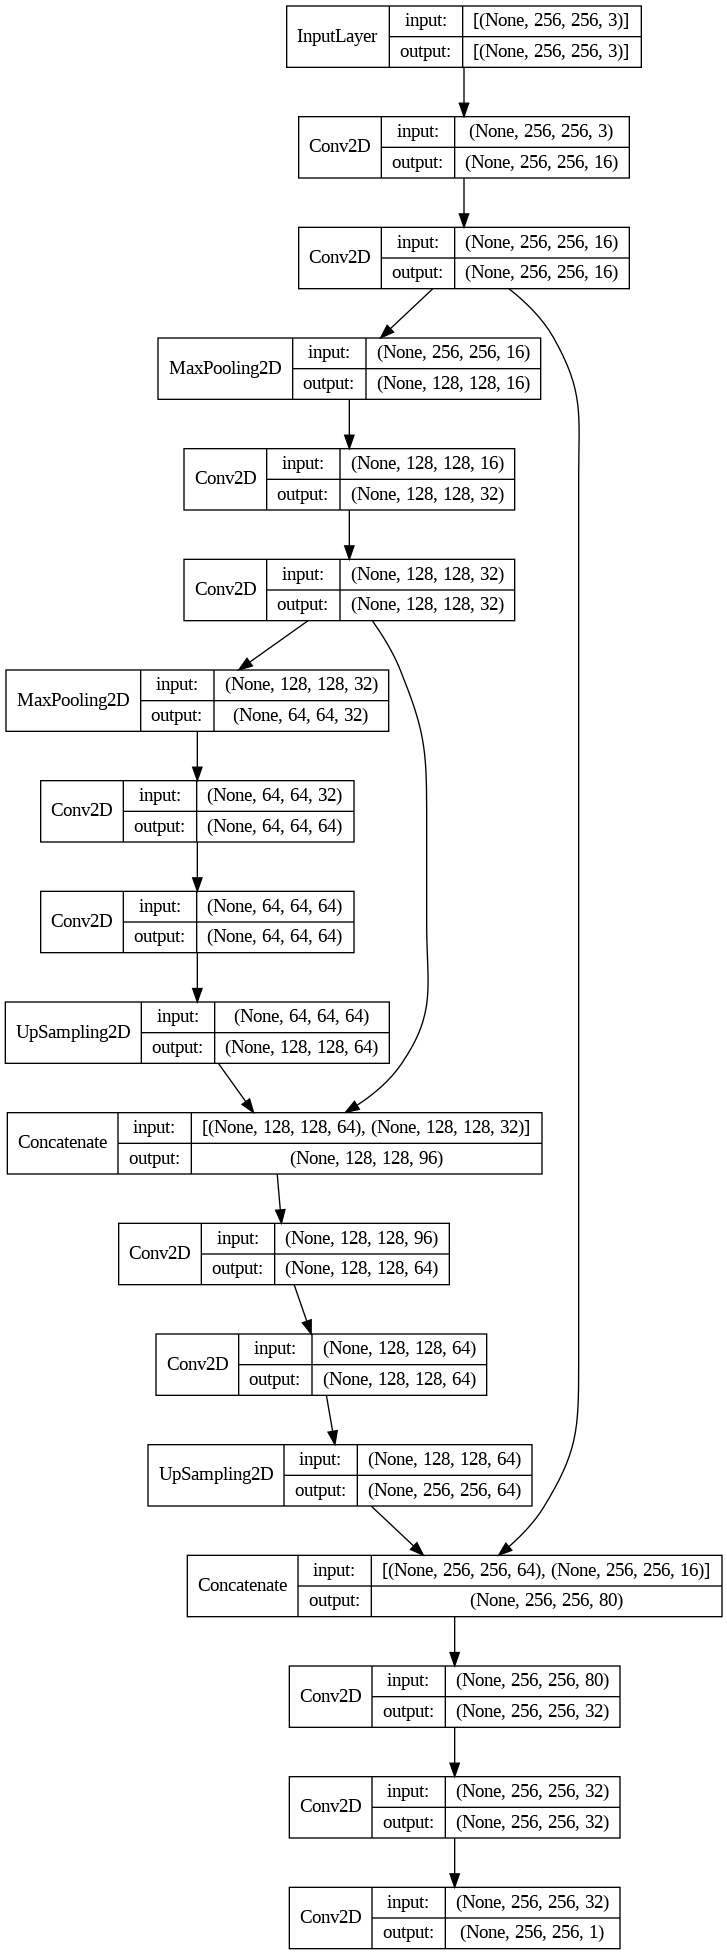

In [ ]:
from keras.utils.vis_utils import plot_model
import tensorflow as tf

num_file = "01"
file_name_f = "model_" + num_f + "_f.png"

tf.keras.utils.plot_model(model, to_file=file_name_f, show_shapes=True, show_dtype=False, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96)


##Print conv

In [ ]:
print("f\n\n", f, "\n")
#print(DECODER, "\n")

for i, layer in enumerate(model.layers):
  #if 'conv' in layer.name:
  if layer.weights:
    print("  ", layer.name, end=" ")
    print(layer.weights[0].shape)
    #print(layer.weights[1].shape)
  else:
    print("       ",layer.name)

  print(i,'-' * 30)

f

 [128] 

        input_1
0 ------------------------------
   conv2d (3, 3, 3, 128)
1 ------------------------------
   conv2d_1 (3, 3, 128, 128)
2 ------------------------------
   conv2d_2 (1, 1, 128, 1)
3 ------------------------------


##model.summary()

In [ ]:
print("f\n\n", f, "\n")
#print(DECODER, "\n")

model.summary()

f

 [128] 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 1)       129       
                                                                 
Total params: 151,297
Trainable params: 151,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/model_s09.png (deflated 13%)
  adding: models/model_f06.png (deflated 17%)
  adding: models/model_s02.png (deflated 15%)
  adding: models/model_f01.png (deflated 19%)
  adding: models/model_s03.png (deflated 10%)
  adding: models/model_s12.png (deflated 9%)
  adding: models/model_s11.png (deflated 11%)
  adding: models/model_f12.png (deflated 13%)
  adding: models/model_s07.png (deflated 10%)
  adding: models/model_s04.png (deflated 10%)
  adding: models/model_s01.png (deflated 15%)
  adding: models/model_s05.png (deflated 18%)
  adding: models/model_f03.png (deflated 18%)
  adding: models/model_s10.png (deflated 10%)
  adding: models/model_f04.png (deflated 18%)
  adding: models/model_f02.png (deflated 19%)
  adding: models/model_f08.png (deflated 17%)
  adding: models/model_f10.png (deflated 14%)
  adding: models/model_f07.png (deflated 19%)
  adding: models/model_f09.png (deflated 17%)
  adding: models/model_f11.png (deflated 12%)
  add

# Others

## plot_VIs_10

In [ ]:
def plot_VIs_10(img, cmap="viridis"): # default cmap="viridis"
    rows = 2
    cols = 5

    #fig, axes = plt.subplots(nm_img_to_plot, cols,
    #     figsize = (cols * figsize, nm_img_to_plot * figsize), squeeze = False)
    fig, axes = plt.subplots(rows, cols, figsize = (15 * rows, 2.5 * cols))

    vi_names = ["01_VARI", "02_ExG", "03_ExR", "04_ExB", "05_EXGR",
               "06_GRVI", "07_MGRVI", "08_GLI", "09_RGBVI", "10_IKAW"]

    posX = 0
    posY = 0
    for vi_num in range(1, 11):
        #print ("vi_num:", vi_num)
        print(vi_names[vi_num - 1])

        vi = return_vi_by_number(img, vi_num)

        print("np.max(vi):", np.max(vi), "np.min(vi):", np.min(vi))
        print("vi.dtype:", vi.dtype, "vi.shape:", vi.shape)
        
        if np.isnan(np.amin(vi)):
            print("Isnan")
            raise Exception("Isnan!")

        #print("axes[",posX, posY,"].")
        axes[posX, posY].set_title(vi_names[vi_num - 1], fontsize=15)

        axes[posX, posY].set_axis_off()

        #axes[posX, posY].imshow(vi)
        axes[posX, posY].imshow(vi, cmap=cmap)

        posY += 1
        if posY == cols:
            posY = 0
            posX += 1

    # set the spacing between subplots
    #fig.tight_layout(pad=0, h_pad=None, w_pad=None, rect=None)
    plt.show()

## test
#imgLoad = "/media/sda2/home/j/Downloads/0del/00/iv/iv_pc_AB/Recortes/Base_A/A_0255.png"
imgLoad = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/A_0001.png"

img = cv2.imread(imgLoad)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img)
print(np.max(img))
print(np.min(img))

plot_VIs_10(img)

plot_VIs_10(img, cmap = "gray")

# https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html
plot_VIs_10(img, cmap = "hot")


## Old make_generator

In [ ]:
# Imports
from skimage.io import imread, imsave
from keras.preprocessing.image import ImageDataGenerator

#        train_generator = make_generator(train_data_frame, batch_size, path, dataset_img_folder,
#                            dataset_mask_folder, aug_dict = data_gen_args, image_color_mode = "rgb",
#                            save_to_dir = save_trans_path, target_size = (image_size, image_size),
#                            seed = seed, use_data_gen_args = use_data_gen_args, shuffle = shuffleData)

#        test_generator = make_generator(test_data_frame, batch_size, path, dataset_img_folder,
#                            dataset_mask_folder, aug_dict = '', image_color_mode = "rgb",
#                            save_to_dir = save_trans_path, target_size = (image_size, image_size),
#                            seed = seed, use_data_gen_args = False, shuffle = shuffleData)

def make_generator(data_frame, batch_size, folder_path, img_folder, mask_folder,
                  aug_dict, image_color_mode = "rgb", mask_color_mode = "grayscale",
                  image_save_prefix = "image", mask_save_prefix = "mask", flag_multi_class = False,
                  num_class = 2, save_to_dir = None, target_size = (256, 256), seed = 42,
                  use_data_gen_args = True, shuffle = False, use_RGB = True):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    If use_data_gen_args True will use aug_dict and make data aumentation
    '''

    #print("\nfolder_path", folder_path)
    #!pwd
    #!ls

    if (use_data_gen_args):
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()

        #image_datagen = ImageDataGenerator(rescale=1./255)
        #mask_datagen = ImageDataGenerator(rescale=1./255)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        folder_path + img_folder,
        x_col = 'filename',
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        shuffle = shuffle,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        folder_path + mask_folder,
        x_col = 'filename',
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = mask_save_prefix,
        shuffle = shuffle,
        seed = seed)

    make_generator_info = zip(image_generator, mask_generator)

    #count_img = len(data_frame)
    #i = 0
    for (img_batch, mask_batch) in make_generator_info:
        #if i == count_img: # restart i to next epoch
            #print("\nNew epoch\n")
            #i = 0

        #img2 = img_batch[0, :, :, :]
        #print(img2.shape)

        #print ("\n\ndata_frame", data_frame[i:i + batch_size])
        #i = i + batch_size
    
        #print("img_batch.shape", img_batch.shape)

        #mask2 = mask_batch[0, :, :, :]
        #print(mask2.shape)

        #imsave("img.png", cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
        #imsave("mask.png", mask2)
        #input()

        img_batch, mask_batch = adjust_data(img_batch, mask_batch, vi_config, use_RGB)

        yield(img_batch, mask_batch)


## loadImgs_new

In [ ]:
#def loadImgs_new(path_list, mode, img_channels):
def loadImgs_new(path_list, mode):
    imgs = []
    #nomes = []
    for path in path_list:
        files = os.listdir(path)
        files.sort()
        print("\npath:", path, " len(files):", len(files))
        for file in files:
            imgPath = os.path.join(path, file)

            #print("loanding img:",len(imgs), imgPath)
            print(file, end = " ")
            img = cv2.imread(imgPath, mode) # 0 grayscale 1 to rgb

            if mode == 0:
                img = np.expand_dims(img, 2)
                
            if mode == 1:
                if vi_config[0]:
                    img = combine_img_VIs(img, vi_config)
                else: #not using VI, adjust img_batch
                    img = img / float(255)

            imgs.append(img)
            #nomes.append(file)

    return np.array(imgs) #, nomes


# Others - tests

## print all ID - name of train_data_frame

In [ ]:
i_index = 0
for i in range(1, 201):
    print("\ni:", i)
    print("\ni_index:", i_index, " to ", i_index + batch_size)
    print ("train_data_frame", train_data_frame[i_index:i_index + batch_size])
    i_index += batch_size


## Test numpy.ndarray nan and inf

In [ ]:
#imgLoad = "/media/sda2/home/j/Downloads/0del/00/iv/iv_pc_AB/Recortes/Base_A/A_0431.png"
imgLoad = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A/A_0431.png"

img = cv2.imread(imgLoad)
print(img.dtype)

img = img.astype('float32')
print(img.dtype)

print("type(img):", type(img))

img[0,0,0] = 0.1
print("\n 0.1/0: ", (img[0,0,0]) / 0)

img[0,0,0] = -0.1
print("-0.1/0:", (img[0,0,0]) / 0)

img[0,0,0] = 0
print(" 0/0:   ", (img[0,0,0]) / 0)
print(" 0/0.1: ", (img[0,0,0]) / 0.1)

# 0/0 = nan
# >0/0 = inf, <0/0 = -inf
# 0/1 = 0.0


## expand_dims np arry img

In [ ]:
#imgLoad = "/media/sda2/home/j/Downloads/0del/00/iv/iv_pc_AB/Recortes/Base_A_mask/A_0001.png"
imgLoad = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/Base_A_mask/A_0001.png"

img = cv2.imread(imgLoad, 0)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

print("img.shape:", img.shape)

img = img / 255.0
img = np.array(img)
print("img.shape:", img.shape)

img = np.expand_dims(img, 2)
print("img.shape:", img.shape)


## Print all VI info

In [ ]:
use_vi = True
vi_to_use = (1,2,3)

vi_config = (use_vi, vi_to_use)

vi_test = vi_config[0]
vi_used = vi_config[1]

print("Using VI:", vi_config[0])
if vi_config[0]:
    print("VI in use:", vi_config[1])
    for val in vi_config[1]:
        print(vi_names[val - 1])


## Restarting kernel

In [ ]:
print("Restarting kernel")
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


## others

In [ ]:
# list of variables
%whos 

#del pr_Imgs

#%whos

In [ ]:
print(dir())

import sys

#del trainImgs
#del nomes
#del validImgs
#del avaliaImgs
#sys.getsizeof(pd)

for var in dir():
    #print(var, type(eval(var)), eval(var), sys.getsizeof(eval(var)))
    print(var, sys.getsizeof(eval(var)))
    #del var


In [ ]:
img = np.random.random((256, 256, len(vi_config[1]) + 3))
print(img.shape)

result = np.empty((0, 256, 256, len(vi_config[1]) + 3)) # First axis is zero, for adding images along it

for i in range(5): # replace this loop with something that reads in the images
    result = np.append(result, img[np.newaxis, ...], axis=0) # add a new axis to each image and append them to result

print(result.shape)